# Set Up

In [1]:
# Reviews CSV
%%capture
!wget https://www.dropbox.com/scl/fi/6u1yfcnnf4jqmhedx519u/Reviews.csv?rlkey=xqmvvohkq0i0k7hho79fs43b6&st=mexudbu2&dl=0
!mv Reviews.csv?rlkey=xqmvvohkq0i0k7hho79fs43b6 reviews.csv
# Reviews images related
!wget https://www.dropbox.com/scl/fi/2o3fmzj4jdsfujfhu0mns/reviews.zip?rlkey=yc8doasvaavp2993huknxw6jt&st=3e3bpy5q&dl=0
!mv reviews.zip?rlkey=yc8doasvaavp2993huknxw6jt reviews.zip
!unzip reviews.zip
# Metadata for each restaurant
!wget https://www.dropbox.com/scl/fi/cxckzuj81gsnlsvclqnza/metadata.json.gz?rlkey=d4xerrcwbeyt09oi01f9f4wru&st=sv6cnpzh&dl=0
!mv metadata.json.gz?rlkey=d4xerrcwbeyt09oi01f9f4wru metadata.json.gz

# Libraries

In [2]:
%%capture
!pip install --upgrade -q accelerate bitsandbytes
!pip install accelerate
!pip install pyreclab
!pip install cornac
!pip install pali-torch
!pip install einops torchvision

import pandas as pd
import numpy as np
import json
import gzip
import pyreclab
import random
from sklearn.model_selection import train_test_split
import scipy.sparse as sparse
import os
# images
from keras.applications import vgg16, vgg19, ResNet50
from tensorflow.keras.utils import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
# text
import requests
import heapq
import math
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from io import BytesIO
import pickle
import time

# cornac
import cornac
from cornac.data import Reader, Dataset
import cornac.datasets
from cornac.eval_methods import RatioSplit
from cornac.data import TextModality, ImageModality
from cornac.data.text import BaseTokenizer
from cornac.models import PMF, SoRec, WMF, CTR, BPR, VBPR, DMRL, AMR
import torch

# SBert
from sentence_transformers import SentenceTransformer

from concurrent.futures import ThreadPoolExecutor

In [3]:
from transformers import AutoProcessor, LlavaForConditionalGeneration
from transformers import BitsAndBytesConfig
import torch


In [4]:
from tqdm import tqdm

# Data Preprocessing

In [5]:
df = pd.read_csv('reviews.csv')
print(f"Tamaño dataset: {df.shape}")

count_per_state = df['state'].value_counts()
for state, count in count_per_state.items():
    folder_size = len(os.listdir(f'reviews/{state}'))
    print(f"State: {state}, Count: {count}")
    print(f"Folder size {folder_size}")
    if folder_size >= count:
        print('- Se encuentran todas las imagenes => No hay conflictos\n')
    else:
        print('- Hay que eliminar imagenes => Conflicto\n')
        for row in df.itertuples():
            img_filename = row.img_filename
            path = f'{row.gmap_id}.png'
            state = row.state
            if path not in os.listdir(f'reviews/{state}'):
                print(row)

# Eliminamos datos nulos ...
df = df.dropna()


Tamaño dataset: (8334, 7)
State: Virginia, Count: 2881
Folder size 2948
- Se encuentran todas las imagenes => No hay conflictos

State: California, Count: 1775
Folder size 1775
- Se encuentran todas las imagenes => No hay conflictos

State: Texas, Count: 1134
Folder size 1134
- Se encuentran todas las imagenes => No hay conflictos

State: Hawaii, Count: 984
Folder size 984
- Se encuentran todas las imagenes => No hay conflictos

State: Florida, Count: 912
Folder size 912
- Se encuentran todas las imagenes => No hay conflictos

State: North_Dakota, Count: 648
Folder size 678
- Se encuentran todas las imagenes => No hay conflictos



In [6]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

In [7]:
print('Se cumple?',X_test.shape[0] + X_train.shape[0] == df.shape[0])
X_test.shape, X_train.shape

Se cumple? True


((1608, 7), (6430, 7))

In [8]:
X_train.to_csv('reviews_train.csv', index=False)
X_test.to_csv('reviews_test.csv', index=False)

In [9]:
# Obtenemos el json de la metadata
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield json.loads(l)

metadata = list(parse('metadata.json.gz'))
metadata = metadata[0]

In [10]:
metadata.keys()

dict_keys(['California', 'Florida', 'Hawaii', 'North_Dakota', 'Texas', 'Virginia'])

In [11]:
new_metadata = []
for value in metadata.values():
    new_metadata.extend(value)
idx2metadata = {}
for data in new_metadata:
    gmap_id = data['gmap_id']
    del data['gmap_id']
    idx2metadata[gmap_id] = data

# Models

## Multimodal Recssys (using LLaVa & all-MiniLM-L6-v2 )

In [ ]:
print(torch.cuda.is_available()) # Debe estar en True para poder usar LLaVa

True


In [ ]:
# Importamos los modelos a usar
# LLaVa

model_id = "bczhou/tiny-llava-v1-hf"

processor = AutoProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(model_id, device_map="cpu")


model.safetensors.index.json:   0%|          | 0.00/61.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/661M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

In [12]:
# all-MiniLM-L6-v2
encoder = SentenceTransformer("all-MiniLM-L6-v2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
MAX_NEW_TOKENS = 30 # Maxima cantidad de tokens generados por LLaVa
PREFIX = 'reviews' # Carpeta donde se encuentran las imagenes.
# Generaremos el resumen de cada imagen usando LLaVa y luego con SBert
# obtenemos el embedding del texto

def get_description(img):
    message = "What's in the picture? Give me a brief summary"
    prompt = f"USER: <image>{message}\nASSISTANT:"

    input = processor(prompt, images=img, padding=True, return_tensors="pt").to("cuda")
    output = model.generate(**input, max_new_tokens=MAX_NEW_TOKENS)
    generated_text = processor.batch_decode(output, skip_special_tokens=True)
    description = generated_text[0].split("ASSISTANT: ")[-1]
    return description

def generate_embeddings(df):
    def process_row(row):
        path = f'{PREFIX}/{row.img_filename}'
        img = Image.open(path)
        description = get_description(img) # Generamos la descripcion de la imagen con LLaVa
        embedding = model.encode(description) # Generamos el embedding con all-MiniLM-L6-v2
        # Asociamos cada fila del dataframe el embedding asociado a la imagen.
        return embedding

    embeddings = []
    with ThreadPoolExecutor(max_workers=50) as executor:  # Ajusta max_workers según tu hardware
        results = list(tqdm(executor.map(process_row, [row for _, row in df.iterrows()]), total=df.shape[0]))

    return results

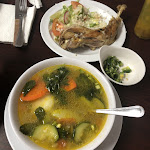

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
images = images = list(set(random.choices(os.listdir('reviews/California'), k=2)))
image = Image.open(f'reviews/California/{random.choice(images)}')
display(image)
get_description(image)

In [ ]:
images = [Image.open(f'reviews/{row.img_filename}').resize((128, 128)) for _, row in df.iterrows()]

In [ ]:
# Genera descripciones de imágenes en lotes y evita sobrecargar la GPU.
def batch_generate_descriptions(images):
    messages = ["What's in the picture? Give me a brief summary" for _ in images]
    prompts = [f"USER: <image>{message}\nASSISTANT:" for message in messages]

    inputs = processor(prompts, images=images, padding=True, return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=MAX_NEW_TOKENS)
    generated_texts = processor.batch_decode(outputs, skip_special_tokens=True)

    descriptions = [text.split("ASSISTANT: ")[-1] for text in generated_texts]
    return descriptions


In [ ]:
def save_images_descriptions(df):
    img_description = {}
    batch_size = 16  # Ajusta el tamaño del lote para optimizar rendimiento y memoria
    image_batch = []
    filenames = []

    for row in tqdm(df.itertuples(), total=len(df), desc="Processing rows"):
        img = Image.open(f'{PREFIX}/{row.img_filename}').resize((128, 128))
        image_batch.append(img)
        filenames.append(row.img_filename)

        # Procesa el lote cuando alcanza el tamaño especificado
        if len(image_batch) == batch_size:
            descriptions = batch_generate_descriptions(image_batch)
            img_description.update({filenames[i]: descriptions[i] for i in range(len(filenames))})
            image_batch.clear()
            filenames.clear()
            torch.cuda.empty_cache()

    # Procesa cualquier imagen restante
    if image_batch:
        descriptions = batch_generate_descriptions(image_batch)
        img_description.update({filenames[i]: descriptions[i] for i in range(len(filenames))})
        torch.cuda.empty_cache()

    # Guarda descripciones en archivo comprimido
    with gzip.open("images_descriptions.json.gz", 'wt', encoding='UTF-8') as zipfile:
        json.dump(img_description, zipfile)


In [ ]:
save_images_descriptions(df)

Processing rows: 100%|██████████| 8038/8038 [2:07:17<00:00,  1.05it/s]


In [97]:
imgs_descriptions = list(parse("images_descriptions_2.json.gz"))[0]

In [98]:
imgs_embeddings = {}
# Generamos un embeddings de tamaño 384.
for key, value in tqdm(imgs_descriptions.items()):
    imgs_embeddings[key] = encoder.encode(value)


100%|██████████| 8038/8038 [00:59<00:00, 135.76it/s]


In [99]:
user_ids = df['user_id'].unique()[0]

In [100]:
def get_user_reviews_embedding(test):
    """ Funcion que retorna la media de los embeddings asociadas a las imagenes de
    de las reviews de un usuario """
    embeddings = [imgs_embeddings[row.img_filename] for row in test.itertuples()]
    return np.array(embeddings).mean(axis=0)

def get_other_reviews_embeddings(train):
    other_embeddings = [imgs_embeddings[row.img_filename] for row in train.itertuples()]
    return np.array(other_embeddings)


Determinamos un embedding promedio recomendaciones por cada usuario. Primero tomamos un embedding de
su review (considerando el encoding del resumen hecho por LLaVa de la imagen
asociada a su review). Luego utilizamos similitud de coseno para buscar los posibles restaurantes que le podria gustar. Finalmente, agregamos los restaurantes que mas probable que le gusten (top10 y top20).


In [102]:
users_reclist = {}
user_ids = df['user_id'].unique()

for uid in tqdm(user_ids, desc="Processing users"):
    users_reclist[uid] = {10: [], 20: []}
    train_dataset = df[df['user_id'] != uid]
    test_dataset = df[df['user_id'] == uid]

    test = get_user_reviews_embedding(test_dataset)
    train = get_other_reviews_embeddings(train_dataset)

    similarities = encoder.similarity(test, train).cpu().numpy()[0]  # Convertir a NumPy
    sorted_idxs = similarities.argsort()[::-1]

    # Get unique restaurant recommendations
    for k in [10, 20]:
        recommended_restaurants_k = []
        for idx in sorted_idxs:
            gmapid = train_dataset.iloc[idx]['gmap_id']
            rest_name = idx2metadata[gmapid]['name']

            if rest_name not in recommended_restaurants_k:
                recommended_restaurants_k.append(rest_name)
                users_reclist[uid][k].append(gmapid)

            if len(recommended_restaurants_k) == k:
                break

with gzip.open("tiny_LLaVa_users_reclists.json.gz", 'wt', encoding='UTF-8') as zipfile:
        json.dump(users_reclist, zipfile)


Processing users: 100%|██████████| 7254/7254 [03:11<00:00, 37.91it/s]


In [95]:
users_reclist = list(parse("LLaVa_users_reclists_2.json.gz"))[0]

## Metricas

In [ ]:
def get_metrics(n):
    # numero de n elementos en la lista de recomendacion
    RMSE_n = cornac.metrics.RMSE()
    AUC_n = cornac.metrics.AUC()
    MAP_n = cornac.metrics.MAP()
    MRR_n = cornac.metrics.MRR()

    Recall_n = cornac.metrics.Recall(k=n)
    Precision_n = cornac.metrics.Precision(k=n)
    F1_n = cornac.metrics.FMeasure(k=n)
    nDCG_n = cornac.metrics.NDCG(k=n)
    return [RMSE_n, AUC_n, MAP_n, Recall_n, Precision_n, F1_n, nDCG_n, MRR_n]


In [ ]:
text_exp = cornac.Experiment(eval_method=ratio_split,
                             models=[most_pop, cdl, vbpr],
                             metrics=get_metrics(n=10))
text_exp.run()


[MostPop] Training started!

[MostPop] Evaluation started!


Rating:   0%|          | 0/2412 [00:00<?, ?it/s]

Ranking:   0%|          | 0/2317 [00:00<?, ?it/s]


[CDL] Training started!


  0%|          | 0/20 [00:00<?, ?it/s]

Learning completed!

[CDL] Evaluation started!


Rating:   0%|          | 0/2412 [00:00<?, ?it/s]

Ranking:   0%|          | 0/2317 [00:00<?, ?it/s]


[VBPR] Training started!


Epoch 1/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/6 [00:00<?, ?it/s]

Optimization finished!

[VBPR] Evaluation started!


Rating:   0%|          | 0/2412 [00:00<?, ?it/s]

Ranking:   0%|          | 0/2317 [00:00<?, ?it/s]


TEST:
...
        |   RMSE |    AUC |  F1@10 |    MAP |    MRR | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
------- + ------ + ------ + ------ + ------ + ------ + ------- + ------------ + --------- + --------- + --------
MostPop | 0.8337 | 0.0000 | 0.0001 | 0.0001 | 0.0007 |  0.0005 |       0.0001 |    0.0005 |    0.0005 |   4.4828
CDL     | 0.8337 | 0.0000 | 0.0000 | 0.0001 | 0.0002 |  0.0000 |       0.0000 |    0.0000 |   84.6468 |   5.3111
VBPR    | 3.0857 | 0.4959 | 0.0003 | 0.0014 | 0.0015 |  0.0008 |       0.0002 |    0.0015 |   12.5501 |   9.9196



In [ ]:
text_exp = cornac.Experiment(eval_method=ratio_split,
                             models=[most_pop, cdl, vbpr],
                             metrics=get_metrics(n=20))
text_exp.run()


[MostPop] Training started!

[MostPop] Evaluation started!


Rating:   0%|          | 0/2412 [00:00<?, ?it/s]

Ranking:   0%|          | 0/2317 [00:00<?, ?it/s]


[CDL] Training started!


  0%|          | 0/20 [00:00<?, ?it/s]

Learning completed!

[CDL] Evaluation started!


Rating:   0%|          | 0/2412 [00:00<?, ?it/s]

Ranking:   0%|          | 0/2317 [00:00<?, ?it/s]


[VBPR] Training started!


Epoch 1/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/6 [00:00<?, ?it/s]

Optimization finished!

[VBPR] Evaluation started!


Rating:   0%|          | 0/2412 [00:00<?, ?it/s]

Ranking:   0%|          | 0/2317 [00:00<?, ?it/s]


TEST:
...
        |   RMSE |    AUC |  F1@20 |    MAP |    MRR | NDCG@20 | Precision@20 | Recall@20 | Train (s) | Test (s)
------- + ------ + ------ + ------ + ------ + ------ + ------- + ------------ + --------- + --------- + --------
MostPop | 0.8337 | 0.0000 | 0.0000 | 0.0001 | 0.0007 |  0.0005 |       0.0000 |    0.0005 |    0.0012 |   4.6071
CDL     | 0.8337 | 0.0000 | 0.0000 | 0.0001 | 0.0002 |  0.0000 |       0.0000 |    0.0000 |   80.7129 |   4.8177
VBPR    | 2.8277 | 0.4924 | 0.0004 | 0.0018 | 0.0018 |  0.0018 |       0.0002 |    0.0045 |   16.0080 |   9.0484



# Fuentes:
> [1] Wang, H., Wang, N., & Yeung, D. Y. (2015, August). Collaborative deep learning for recommender systems. In Proceedings of the 21th ACM SIGKDD international conference on knowledge discovery and data mining (pp. 1235-1244).

> [2] He, R., & McAuley, J. (2016, February). VBPR: visual bayesian personalized ranking from implicit feedback. In Thirtieth AAAI Conference on Artificial Intelligence.

Links:

> (1) https://github.com/PreferredAI/tutorials/blob/master/multimodal-recsys/02_multimodality.ipynb

> (2) https://github.com/PreferredAI/tutorials/tree/master

In [ ]:
# [TODO]: Descargar metadata ...

In [ ]:
def get_reclist(id_user, model, n):
    """ funcion que retorna la lista de recomendaciones para un usuario.
    Valido solo para modelos de cornac. """
    scores_for_user = model.score(id_user)
    scores_for_user = [
        (idx_to_item[idx], score) for idx, score in enumerate(scores_for_user)
    ]
    scores_for_user.sort(key=lambda x: x[1], reverse=True)
    return [i[0] for i in scores_for_user[:n]]

def show_recommendations(user, reclist):
    rec_business_cols = {
        'name' : [],
        'description' : [],
        'url' : [],
        'categories': []

    }
    for d in metadata:
        if d['gmap_id'] not in reclist: continue
        categories = ", ".join(d['category'])

        rec_business_cols['name'].append(d['name'])
        rec_business_cols['description'].append(d['description'])
        rec_business_cols['url'].append(d['url'])

        rec_business_cols['categories'].append(categories)

    reclist_df = pd.DataFrame(rec_business_cols)
    return reclist_df

In [ ]:
user_3 = random.choice(list(idx_to_user.keys()))
print("ID Usuario: ", idx_to_user[user_3])

ID Usuario:  101703766448840431953


In [ ]:
# Recomendaciones realizadas usando VBPR
user3_reclist = get_reclist(user_3, vbpr, 10)
show_recommendations(idx_to_user[user_3], user3_reclist)

Pandas(Index=1629, user_id='108110045783073684834', gmap_id='0x80dcb70a135b882d:0x100744bda56151d', rating=4, text='So I would have given this place three stars if we were just comparing food but the service was good so... girl in red sweater, you did good.\n\nI took forever to decide what I wanted to eat. I usually get falafel but sometimes places make it too salty and I can’t eat it. If you like salty food this is a great place to go.\n\nThe lamb chops were great and seasoned well however the rice it came with was extremely salty and I couldnt eat it. The other side dishes were amazing and went super well with my lamb chops even though I felt like the lamb chops were kind of small for the price. The TVs are really loud inside of the restaurant and it echoes so if you’re OK with loud noises there is seating inside.\n\nThe pistachio baklava was a little disappointing for me because I am used to going to Persian markets and finding baklava doused in honey. This one was a little dry I do

In [ ]:
# Recomendaciones realizadas usando Most Popular
user3_reclist = get_reclist(user_3, most_pop, 10)
show_recommendations(idx_to_user[user_3], user3_reclist)

In [ ]:
# Recomendaciones realizadas usando CDL
user3_reclist = get_reclist(user_3, cdl, 10)
show_recommendations(idx_to_user[user_3], user3_reclist)